In [1]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer

import presentation as p

# reading in relevant data frames

training_df_scaled_enc_le_clean = pd.read_csv('data/training_df_scaled_enc_le_clean.csv', index_col=None)
training_df_enc_le_clean = pd.read_csv('data/training_df_enc_le_clean.csv', index_col=None)
testing_df_scaled_enc_le_clean = pd.read_csv('data/testing_df_scaled_enc_le_clean.csv', index_col=None)
testing_df_enc_le_clean = pd.read_csv('data/testing_df_enc_le_clean.csv', index_col=None)

X_train_is_attack = training_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_train_is_attack = training_df_scaled_enc_le_clean.is_attack
y_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].target_group
X_test_is_attack = testing_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_test_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_true_is_attack = testing_df_scaled_enc_le_clean.is_attack
y_true_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

# Metrics
beta = 10
fbeta_average = 'weighted'

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('EvaluationResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=False):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return eval_result(model, acc, fbeta)

We found the best random forest classifier on the reduced dataset with the following details:

## Attack Detection

```txt
-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	10
	n_estimators:	100
	n_jobs:	-1
	random_state:	404
Best Score:
	0.997664

-- Testing Results --
Accuracy    on Verification Data:	0.925606
Fbeta scroe on Verification Data:	0.925486

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.99      0.81      0.89     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.90      0.92     77291
weighted avg       0.93      0.93      0.92     77291
```

## Attack Classification

```txt
-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	20
	n_jobs:	-1
	random_state:	404
Best Score:
	0.844451

-- Testing Results --
Accuracy    on Verification Data:	0.906767
Fbeta scroe on Verification Data:	0.906661

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23747
           2       0.62      0.82      0.70      3041
           3       0.82      0.50      0.62      2533
           4       0.14      0.16      0.15        57

    accuracy                           0.91     29378
   macro avg       0.64      0.61      0.61     29378
weighted avg       0.91      0.91      0.91     29378
```

Now, we will use this parameterset and train the classifier on the entire dataset.

In [2]:
model_is_attack = RandomForestClassifier(
    criterion='entropy',
    max_depth=10,
    n_estimators=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=404
).fit(X_train_is_attack, y_train_is_attack)

In [3]:
y_pred_is_attack = model_is_attack.predict(X_test_is_attack)

In [4]:
result_is_attack = evaluate_model(model_is_attack, X_test_is_attack, y_true_is_attack, display_false_negatives=True)


-- Testing Results --
Accuracy    on Verification Data:	0.937936
Fbeta scroe on Verification Data:	0.937933

              precision    recall  f1-score   support

       False       0.94      0.96      0.95     47913
        True       0.93      0.91      0.92     29378

    accuracy                           0.94     77291
   macro avg       0.94      0.93      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 2677 (9.112% out of 29378 attacks, 3.464% overall)



In [20]:
_ = evaluate_model(model_is_attack, X_test_is_attack, y_true_is_attack, display_false_negatives=True, average='binary')


-- Testing Results --
Accuracy    on Verification Data:	0.937936
Fbeta scroe on Verification Data:	0.909048

              precision    recall  f1-score   support

       False       0.94      0.96      0.95     47913
        True       0.93      0.91      0.92     29378

    accuracy                           0.94     77291
   macro avg       0.94      0.93      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 2677 (9.112% out of 29378 attacks, 3.464% overall)



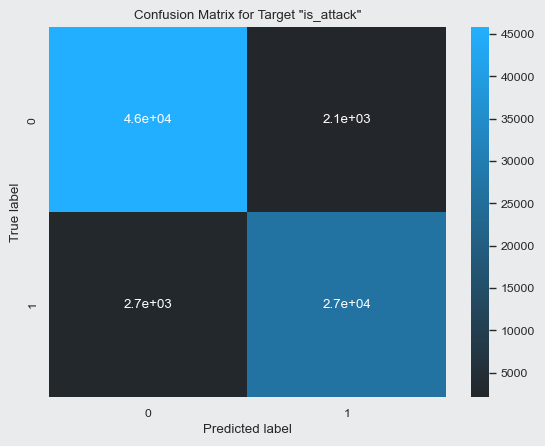

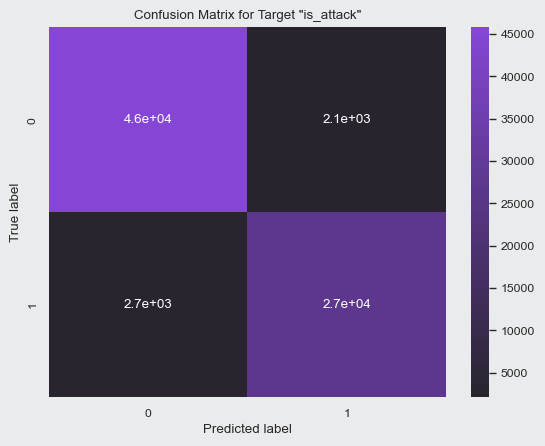

In [6]:
simple_confusion_matrix(y_true_is_attack, y_pred_is_attack, 'is_attack')

In [7]:
model_attack_group = RandomForestClassifier(
	criterion='gini',
	max_depth=20,
	n_estimators=20,
	bootstrap=True,
    n_jobs=-1,
    random_state=404,
).fit(X_train_attack_group, y_train_attack_group)

In [8]:
y_pred_attack_group = model_attack_group.predict(X_test_attack_group)

In [18]:
result_attack_group = evaluate_model(model_attack_group, X_test_attack_group, y_true_attack_group)


-- Testing Results --
Accuracy    on Verification Data:	0.901116
Fbeta scroe on Verification Data:	0.901004

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     23747
           2       0.53      0.80      0.64      3041
           3       0.98      0.49      0.65      2533
           4       0.44      0.49      0.46        57

    accuracy                           0.90     29378
   macro avg       0.73      0.69      0.68     29378
weighted avg       0.93      0.90      0.90     29378



In [15]:
_ = evaluate_model(model_attack_group, X_test_attack_group, y_true_attack_group, average='macro')


-- Testing Results --
Accuracy    on Verification Data:	0.901116
Fbeta scroe on Verification Data:	0.685390

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     23747
           2       0.53      0.80      0.64      3041
           3       0.98      0.49      0.65      2533
           4       0.44      0.49      0.46        57

    accuracy                           0.90     29378
   macro avg       0.73      0.69      0.68     29378
weighted avg       0.93      0.90      0.90     29378



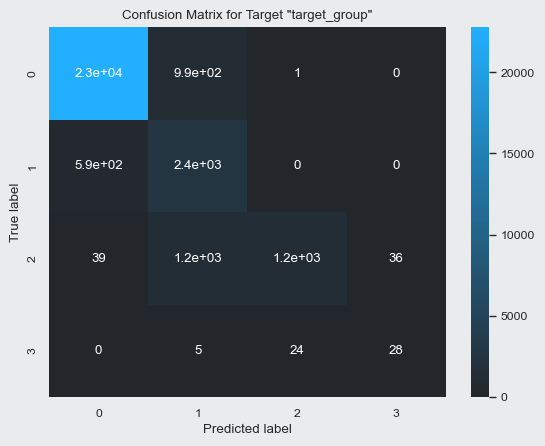

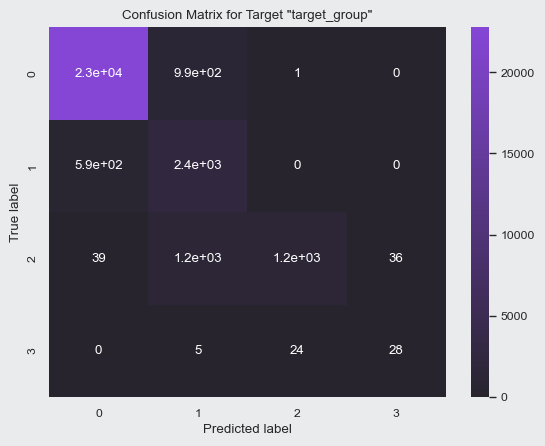

In [16]:
simple_confusion_matrix(y_true_attack_group, y_pred_attack_group, 'target_group')